# Mongabay deforestation charts tool

This notebook explores the data for mongabay deforestation charts under the charts tool.
The main requirements are defined [here](https://docs.google.com/document/d/17U4nyDrYOw64ptzFe6IPMGyOX0UpgktmphFtIEGOcm4/edit#)

The data used on this exploration in based on a dirty dataset sourced [here](https://docs.google.com/spreadsheets/d/1KGb2Enin_EWTiZy7uHaCN_v6NEdddT77E9KemJh2ruI/edit#gid=301020640)

**Note about data processing requirements:**

The data came from different sources:
* Sensors:
    * Deter from INPE  
    * SAD from Imazon  
    * PRODES from INPE  
    * Forest loss from UMD - Matt Hansen 
* Locations:
    * Brazil administrative regions (Country and first level) 
    * Brazil Biomes

The data needs to be adapted to the next data model:  
| date | scenario  | timestep | location | driver | sensor | value | unit |
|------|-----------|----------|----------|--------|--------|-------|------|
|      |           |          |          |        |        |       |      |  


Depending on the sensor the data aquisition will variate: 
* From UMD and administrative levels we will need to use [gfw data api](https://data-api.globalforestwatch.org/dataset/gadm__tcl__iso_change/v20221012/query/json), for biomes we will need to calculate ourselves or make use of gfw areas of interest. 
* From deter and prodes that cames from INPE data will came from [terrabrasilis](http://terrabrasilis.dpi.inpe.br/) but we will need to check if the Locations are properly captured. If not we will need to perform such calculations from raw data
* SAD came from imazon https://imazongeo.org.br/#/
* Also there is an alternative source we could explore https://plataforma.alerta.mapbiomas.org/


## Metrics

Let's start by defining the metrics we will use to explore the data.  
* moving averages (MA)
* cumulative moving averages (CMA)
* exponential moving averages (EMA)
* moving average convergence/divergence (MACD)
* cumulative summation (CSUM)




In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [37]:
sheet_id = "1KGb2Enin_EWTiZy7uHaCN_v6NEdddT77E9KemJh2ruI"
sheet_name = "data"
dtypes = {
    "scenario": "category",
    "timestep": "category",
    "location": "category",
    "driver": "category",
    "sensor": "category",
}
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
data = pd.read_csv(url, dtype=dtypes, parse_dates=["date"])
data["value"] = data["value"].str.replace(",", "").astype(float).round(4)
data.head()

,date,scenario,timestep,location,driver,sensor,value,unit
0,1988-01-01,deforestation,year,brazil,total,prodes,21050.0,sqkm
1,1989-01-01,deforestation,year,brazil,total,prodes,17770.0,sqkm
2,1990-01-01,deforestation,year,brazil,total,prodes,13730.0,sqkm
3,1991-01-01,deforestation,year,brazil,total,prodes,11030.0,sqkm
4,1992-01-01,deforestation,year,brazil,total,prodes,13786.0,sqkm


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      455 non-null    datetime64[ns]
 1   scenario  455 non-null    category      
 2   timestep  455 non-null    category      
 3   location  455 non-null    category      
 4   driver    455 non-null    category      
 5   sensor    455 non-null    category      
 6   value     454 non-null    float64       
 7   unit      455 non-null    object        
dtypes: category(5), datetime64[ns](1), float64(1), object(1)
memory usage: 13.4+ KB


# Deforestation data

In [102]:
data_pivot = (
    data[(data["timestep"] == "year") & (data["location"] == "brazil")]
    .pivot(index="date", columns="sensor", values="value")
    .dropna()
)
data_pivot["umd_forest_loss"] = data_pivot["umd_forest_loss"] * 0.01  # ha to km2
data_pivot.head()

sensor,prodes,umd_forest_loss
date,,
2001-01-01,18165.0,27463.61557
2002-01-01,21651.0,35070.49440
2003-01-01,25396.0,32485.26734
2004-01-01,27772.0,38487.70790
2005-01-01,19014.0,34865.62705


<AxesSubplot: xlabel='date'>

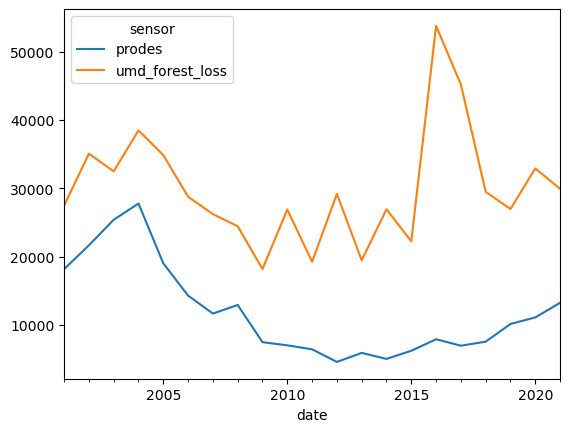

In [103]:
data_pivot.plot()

<AxesSubplot: xlabel='date'>

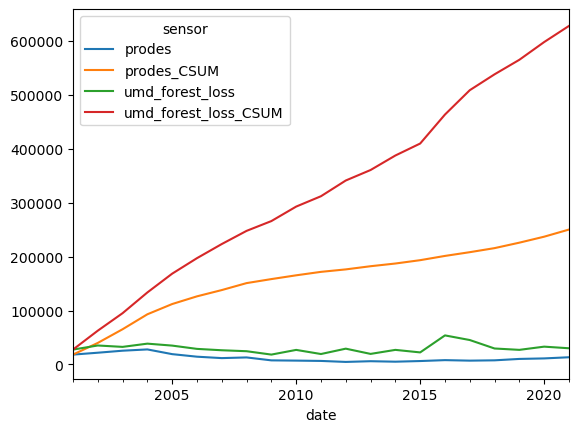

In [106]:
data_pivot["prodes_CSUM"] = data_pivot["prodes"].cumsum()
data_pivot["umd_forest_loss_CSUM"] = data_pivot["umd_forest_loss"].cumsum()
data_pivot[["prodes", "prodes_CSUM", "umd_forest_loss", "umd_forest_loss_CSUM"]].plot()

# Alerts

In [84]:
data_pivot = data[
    (data["timestep"] == "monthly") & (data["location"] == "brazil")
].pivot(index="date", columns="sensor", values="value")

data_pivot["deter_merge"] = data_pivot[["deter", "deter-b"]].bfill(axis=1).iloc[:, 0]
data_pivot.head()

sensor,deter,deter-b,sad,deter_merge
date,,,,
2007-04-01,64.45,NaN,106.0,64.45
2007-05-01,1222.33,NaN,398.0,1222.33
2007-06-01,1398.17,NaN,499.0,1398.17
2007-07-01,1025.38,NaN,961.0,1025.38
2007-08-01,190.93,NaN,663.0,190.93


<AxesSubplot: xlabel='date'>

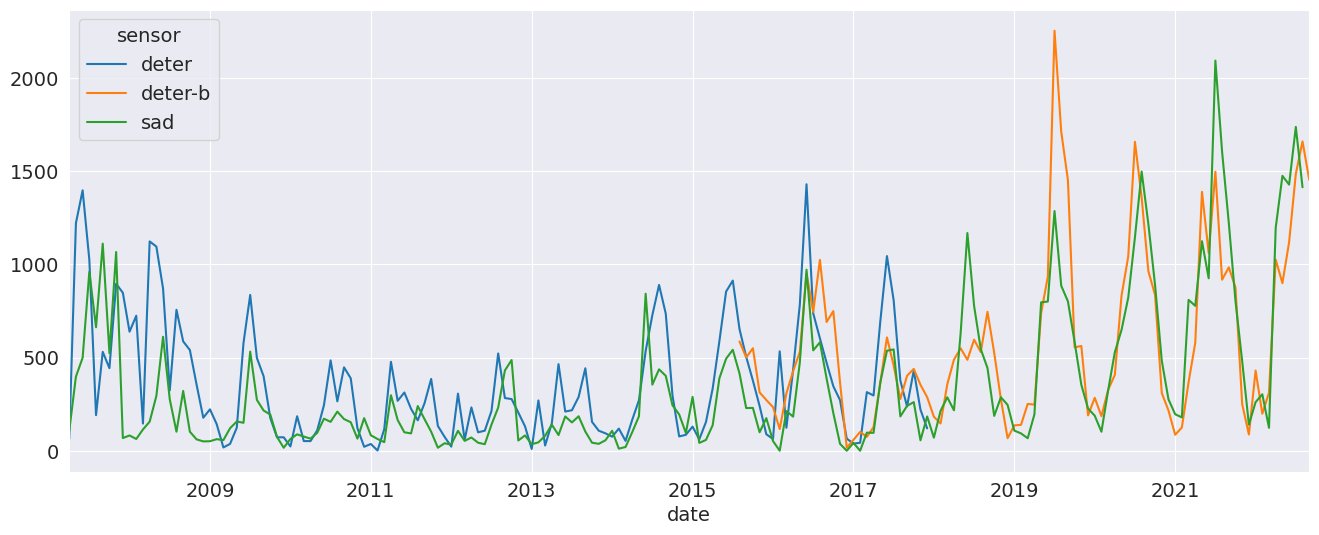

In [209]:
data_pivot[["deter", "deter-b", "sad"]].plot()

### Moving averages

<AxesSubplot: xlabel='date'>

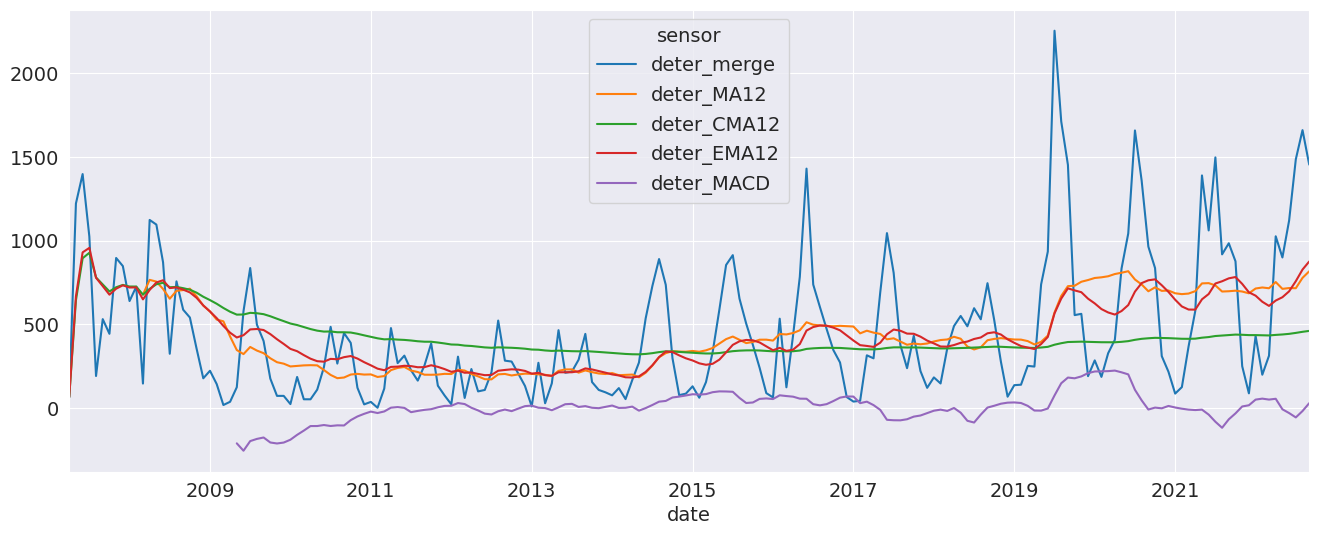

In [205]:
data_pivot["deter_CMA12"] = data_pivot["deter_merge"].expanding().mean()
data_pivot["deter_EMA12"] = data_pivot["deter_merge"].ewm(12).mean()
data_pivot["deter_MA12"] = data_pivot["deter_merge"].rolling(12).mean()
data_pivot["deter_MACD"] = (
    data_pivot["deter_merge"].rolling(12).mean()
    - data_pivot["deter_merge"].rolling(26).mean()
)
data_pivot[
    ["deter_merge", "deter_MA12", "deter_CMA12", "deter_EMA12", "deter_MACD"]
].plot()

<AxesSubplot: xlabel='date'>

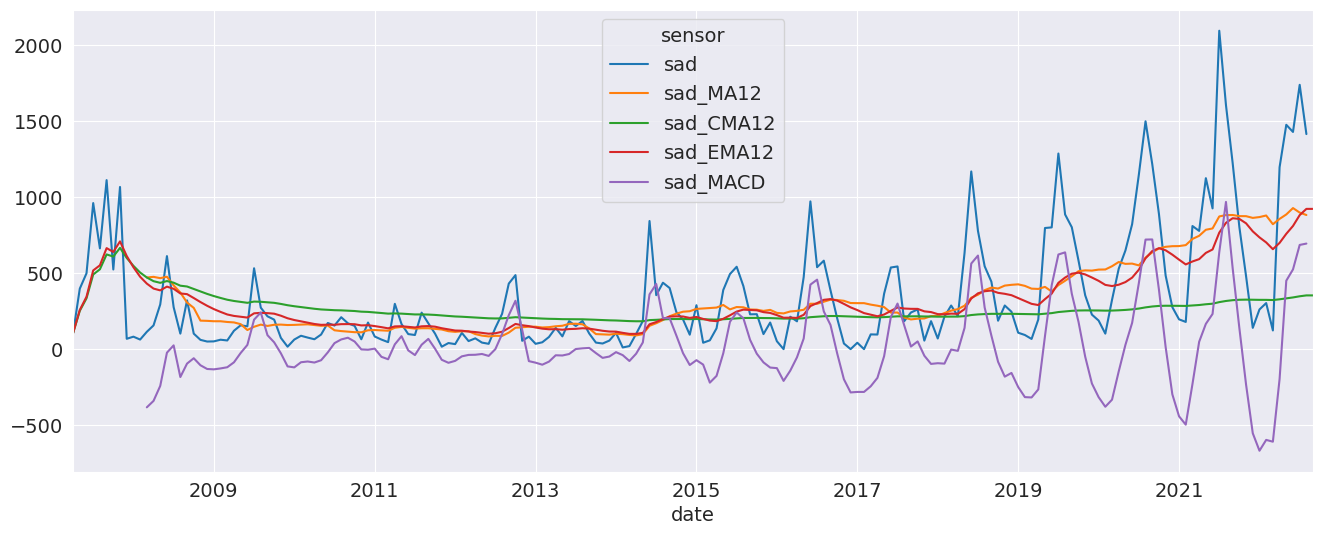

In [213]:
data_pivot["sad_CMA12"] = data_pivot["sad"].expanding().mean()
data_pivot["sad_EMA12"] = data_pivot["sad"].ewm(12).mean()
data_pivot["sad_MA12"] = data_pivot["sad"].rolling(12).mean()
data_pivot["sad_MACD"] = (
    data_pivot["sad"].rolling(2).mean() - data_pivot["sad"].rolling(12).mean()
)

data_pivot[["sad", "sad_MA12", "sad_CMA12", "sad_EMA12", "sad_MACD"]].plot()

<AxesSubplot: xlabel='date'>

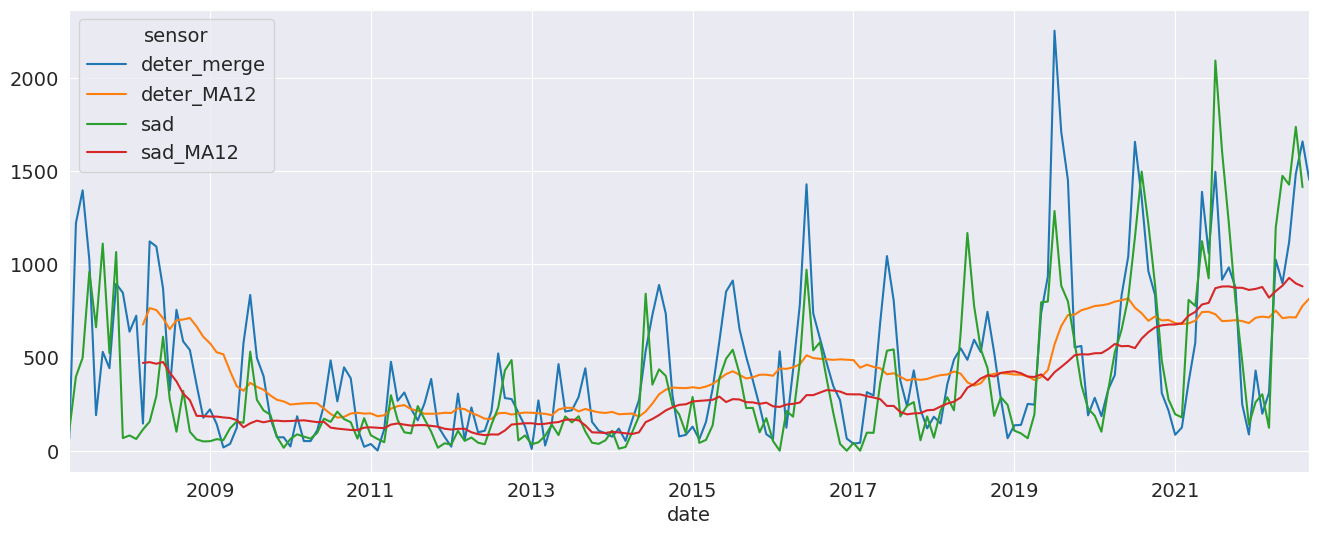

In [207]:
fig = plt.figure(figsize=(12, 8))

data_pivot[["deter_merge", "deter_MA12", "sad", "sad_MA12"]].plot()

<AxesSubplot: xlabel='date'>

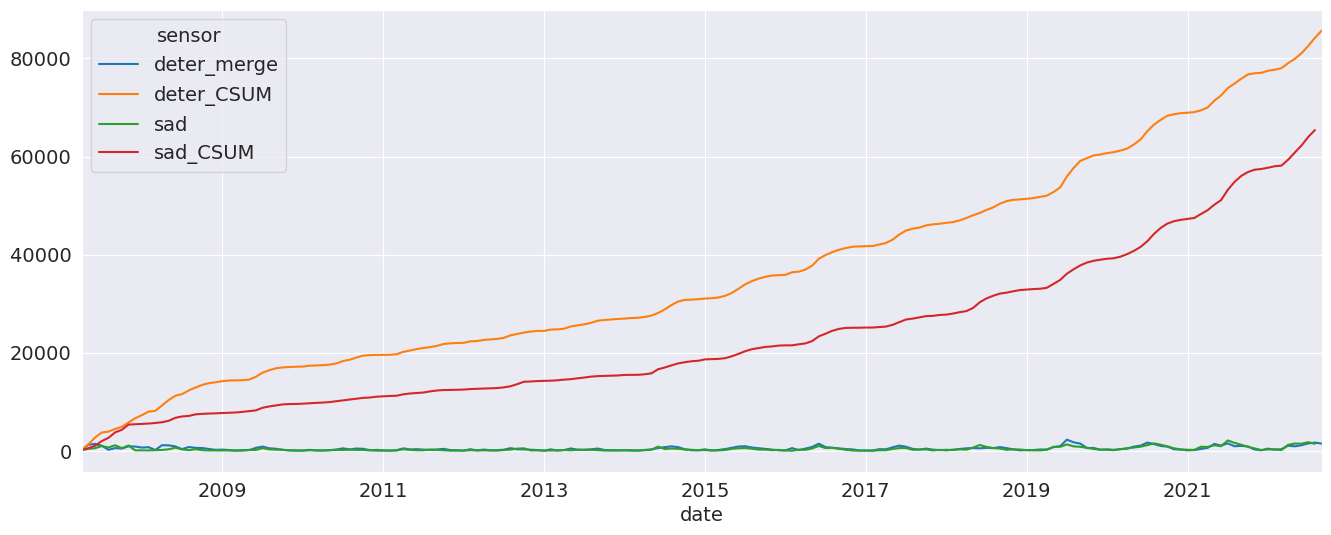

In [208]:
data_pivot["deter_CSUM"] = data_pivot["deter_merge"].cumsum()
data_pivot["sad_CSUM"] = data_pivot["sad"].cumsum()
data_pivot[["deter_merge", "deter_CSUM", "sad", "sad_CSUM"]].plot()

## Indepth exploration

In here i will want to explore a bit more in depth the timeseries of the alerts.
In order to do so i will perform first a exploratory analysis. Exploring the trends, seasonality, cyclic behavior, variation and autocorrelation of the data.



In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
import statsmodels.api as sm
from statsmodels.stats import descriptivestats
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.signal import periodogram

In [7]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [144]:
sheet_id = "1KGb2Enin_EWTiZy7uHaCN_v6NEdddT77E9KemJh2ruI"
sheet_name = "data"
dtypes = {
    "scenario": "category",
    "timestep": "category",
    "location": "category",
    "driver": "category",
    "sensor": "category",
}
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
data = pd.read_csv(url, dtype=dtypes, parse_dates=["date"])
data["value"] = data["value"].str.replace(",", "").astype(float).round(4)
data.head()

,date,scenario,timestep,location,driver,sensor,value,unit
0,1988-01-01,deforestation,year,brazil,total,prodes,21050.0,sqkm
1,1989-01-01,deforestation,year,brazil,total,prodes,17770.0,sqkm
2,1990-01-01,deforestation,year,brazil,total,prodes,13730.0,sqkm
3,1991-01-01,deforestation,year,brazil,total,prodes,11030.0,sqkm
4,1992-01-01,deforestation,year,brazil,total,prodes,13786.0,sqkm


In [145]:
series = ["deter", "deter-b", "sad", "deter_merge"]
data_pivot = data[
    (data["timestep"] == "monthly") & (data["location"] == "brazil")
].pivot(index="date", columns="sensor", values="value")
data_pivot[series[3]] = data_pivot[series[:2]].bfill(axis=1).iloc[:, 0]
data_pivot.head()

sensor,deter,deter-b,sad,deter_merge
date,,,,
2007-04-01,64.45,NaN,106.0,64.45
2007-05-01,1222.33,NaN,398.0,1222.33
2007-06-01,1398.17,NaN,499.0,1398.17
2007-07-01,1025.38,NaN,961.0,1025.38
2007-08-01,190.93,NaN,663.0,190.93


In [172]:
descriptivestats.Description(data_pivot).frame

sensor,deter,deter-b,sad,deter_merge
nobs,1.860000e+02,186.000000,1.860000e+02,1.860000e+02
missing,5.700000e+01,100.000000,1.000000e+00,0.000000e+00
mean,3.588702e+02,596.598721,3.535243e+02,4.605644e+02
std_err,2.781308e+01,50.393731,2.902291e+01,3.065508e+01
upper_ci,4.133829e+02,695.368619,4.104082e+02,5.206473e+02
lower_ci,3.043576e+02,497.828823,2.966405e+02,4.004815e+02
std,3.158958e+02,467.332235,3.947543e+02,4.180796e+02
iqr,4.035900e+02,609.717500,3.990000e+02,5.062500e+02
iqr_normal,2.991817e+02,451.984259,2.957791e+02,3.752837e+02
mad,2.508214e+02,367.135078,2.964218e+02,3.254279e+02


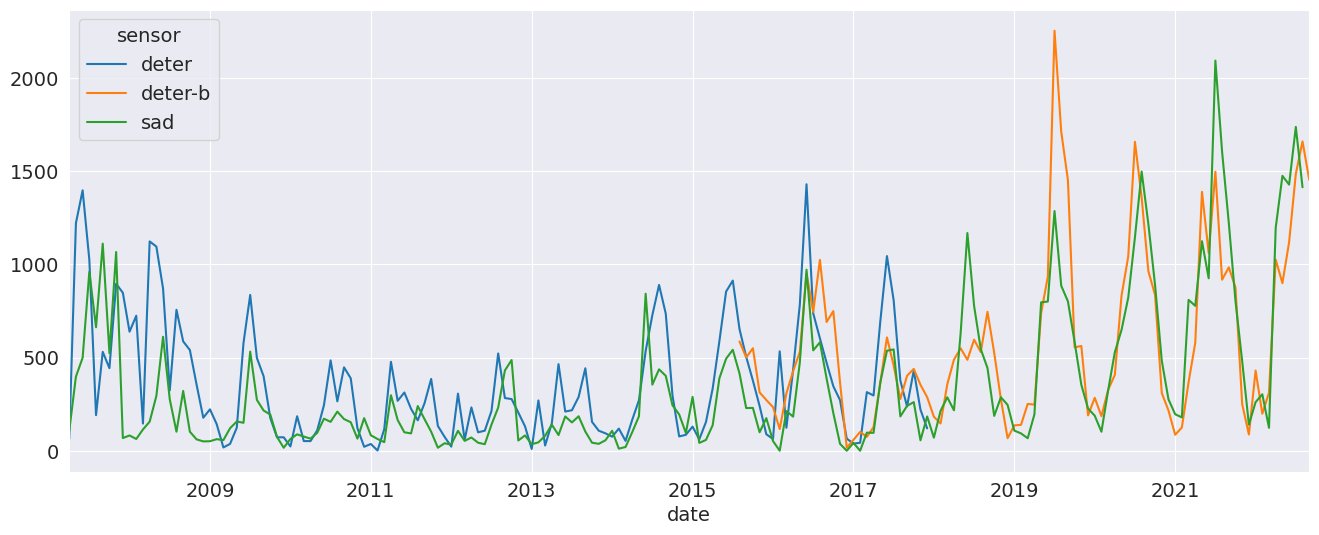

In [146]:
data_pivot = data_pivot.asfreq("MS")
fig, ax = plt.subplots()
ax = data_pivot[series[:3]].plot(ax=ax)

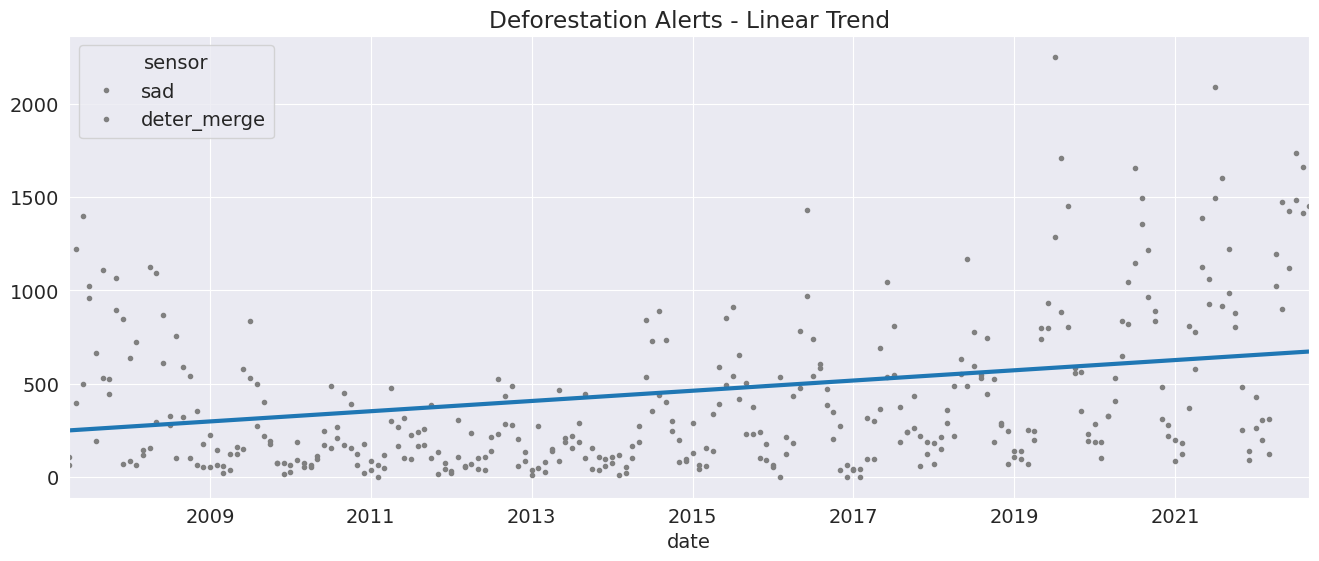

In [220]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=data_pivot.index,  # dates from the training data
    constant=True,  # dummy feature for the bias (y_intercept)
    order=1,  # the time dummy (trend)
    drop=True,  # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

y = data_pivot[series[3]]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = data_pivot[series[2:]].plot(
    style=".", color="0.5", title="Deforestation Alerts - Linear Trend"
)
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

## Periodogram

In [199]:
def plot_periodogram(ts, detrend="linear", ax=None, title="Periodogram"):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling="spectrum",
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(title)
    return ax

/tmp/ipykernel_57/655861503.py:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


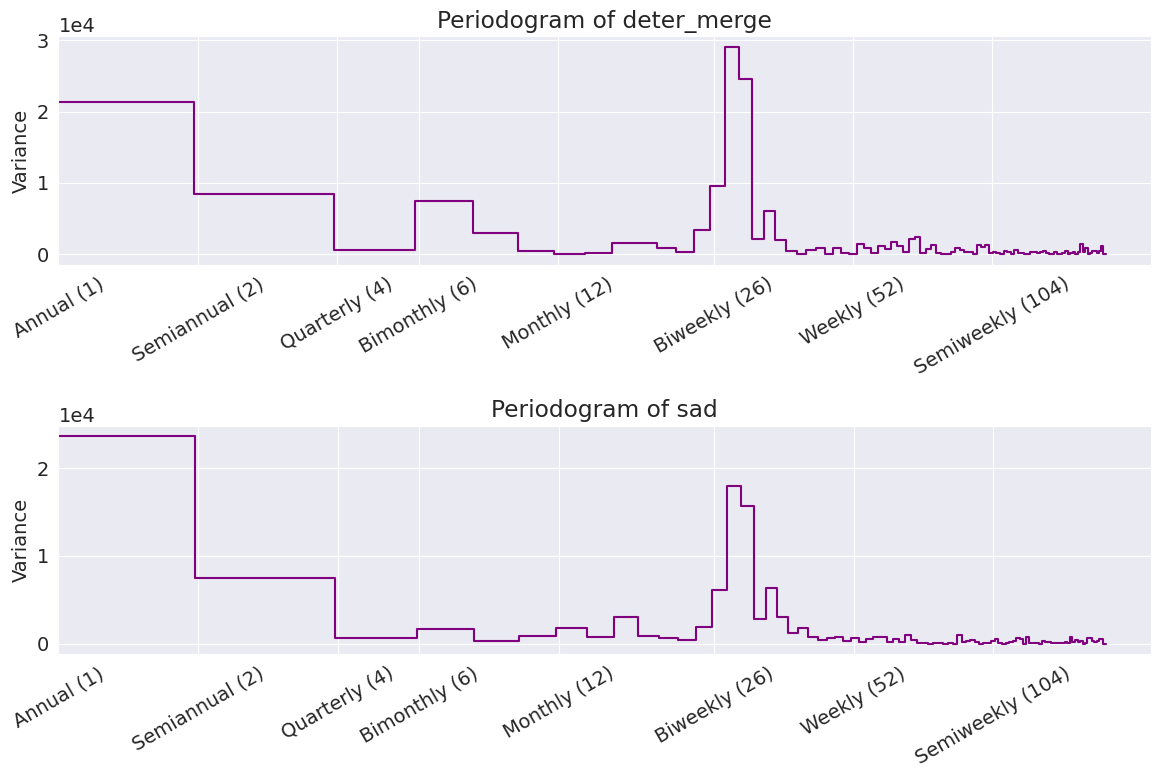

In [204]:
fig = plt.figure(figsize=(12, 8))
plot_periodogram(
    data_pivot[series[3]], ax=fig.add_subplot(211), title=f"Periodogram of {series[3]}"
)
plot_periodogram(
    data_pivot[series[2]].dropna(),
    ax=fig.add_subplot(212),
    title=f"Periodogram of {series[2]}",
)
fig.tight_layout()

## Correlogram for deter and sad

We are looking for linear dependencies between the data.

/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


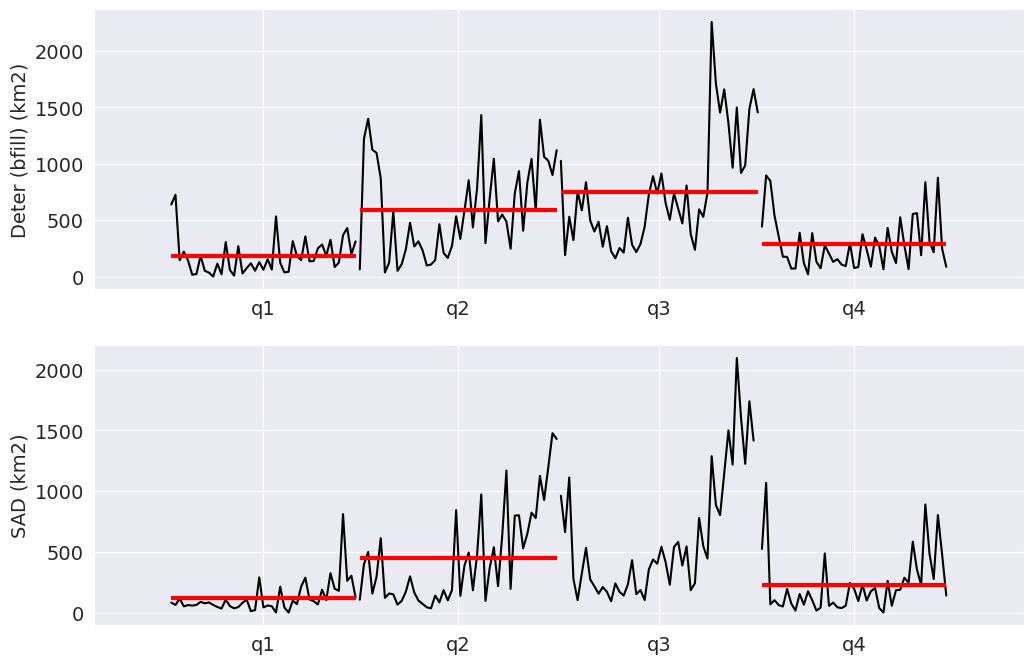

In [212]:
fig = plt.figure(figsize=(12, 8))
fig = sm.tsa.graphics.quarter_plot(
    data_pivot.to_period("Q")[series[3]],
    ax=fig.add_subplot(211),
    ylabel="Deter (bfill) (km2)",
)
fig = sm.tsa.graphics.quarter_plot(
    data_pivot.to_period("Q")[series[2]], ax=fig.add_subplot(212), ylabel="SAD (km2)"
)

/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


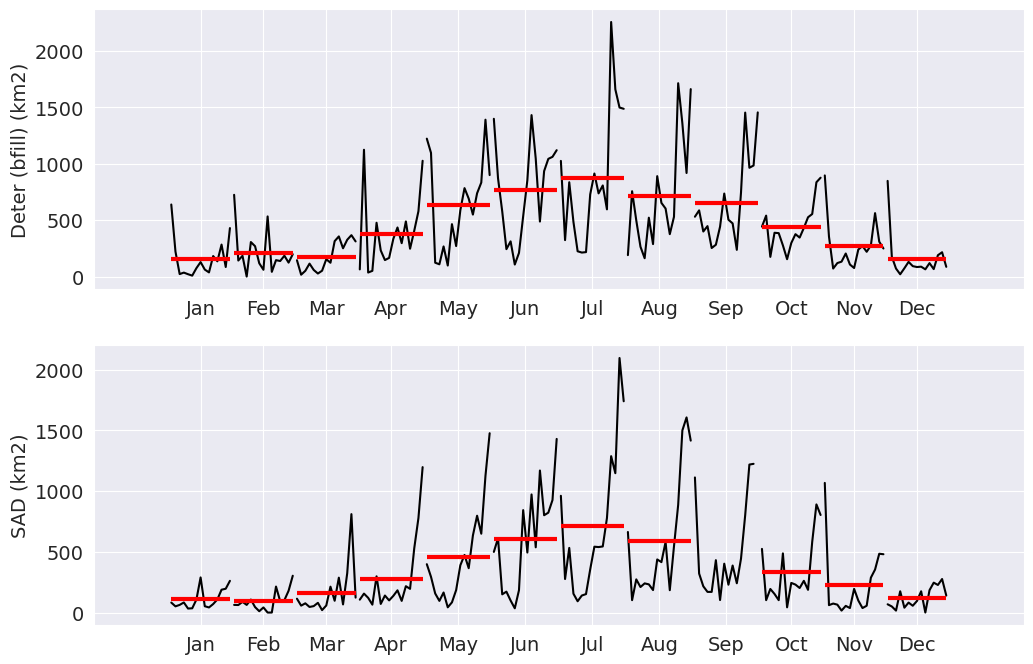

In [189]:
fig = plt.figure(figsize=(12, 8))
fig = sm.tsa.graphics.month_plot(
    data_pivot[series[3]], ax=fig.add_subplot(211), ylabel="Deter (bfill) (km2)"
)
fig = sm.tsa.graphics.month_plot(
    data_pivot[series[2]], ax=fig.add_subplot(212), ylabel="SAD (km2)"
)

/opt/conda/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


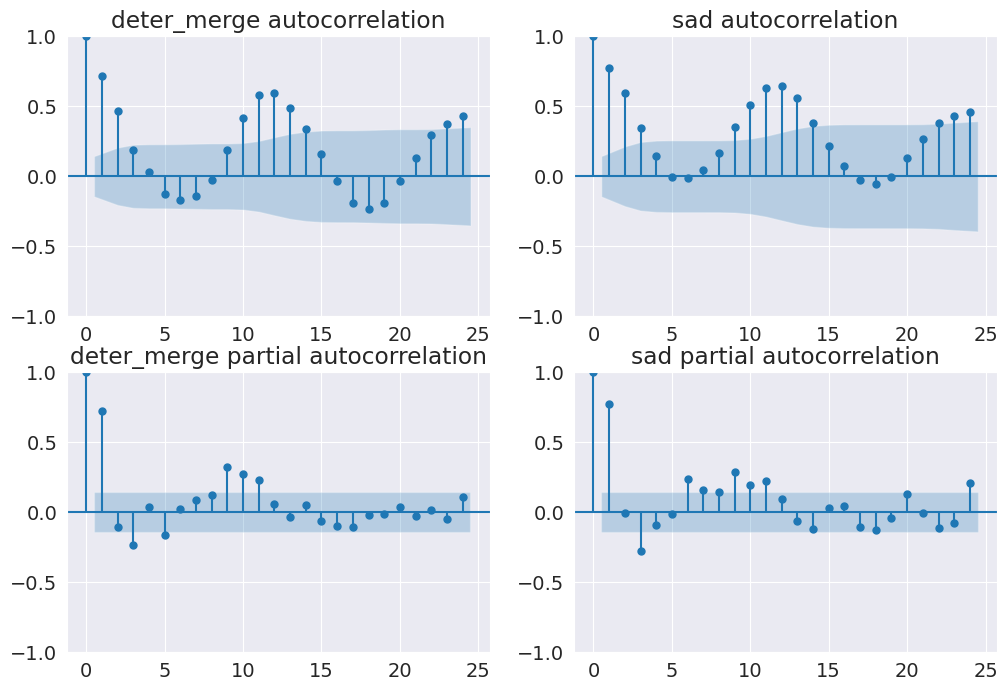

In [221]:
period = 24
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.tsa.plot_acf(
    data_pivot[series[3]].values.squeeze(),
    lags=period,
    ax=fig.add_subplot(221),
    title=f"{series[3]} autocorrelation",
)
fig = sm.graphics.tsa.plot_pacf(
    data_pivot[series[3]],
    lags=period,
    ax=fig.add_subplot(223),
    title=f"{series[3]} partial autocorrelation",
)
fig = sm.graphics.tsa.plot_acf(
    data_pivot[series[2]].dropna().values.squeeze(),
    lags=period,
    ax=fig.add_subplot(222),
    title=f"{series[2]} autocorrelation",
)
fig = sm.graphics.tsa.plot_pacf(
    data_pivot[series[2]].dropna(),
    lags=period,
    ax=fig.add_subplot(224),
    title=f"{series[2]} partial autocorrelation",
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    sad   No. Observations:                  185
Model:                    AutoReg(12)   Log Likelihood               -1144.177
Method:               Conditional MLE   S.D. of innovations            180.333
Date:                Wed, 21 Dec 2022   AIC                           2316.354
Time:                        12:13:19   BIC                           2360.501
Sample:                    04-01-2008   HQIC                          2334.264
                         - 08-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6657     23.778      0.070      0.944     -44.938      48.269
sad.L1         0.5039      0.075      6.710      0.000       0.357       0.651
sad.L2         0.1301      0.084      1.555      0.120      -0.034       0.294
sad.L3        -0.0158      0.084     -0.187      0.851      -0.181       0.150
sad.L4        -0.0755      0.083     -0.907      0.365      -0.239       0.088
sad.L5        -0.0732      0.081     -0.905      0.365      -0.232       0.085
sad.L6         0.0367      0.083      0.442      0.658      -0.126       0.199
sad.L7         0.0249      0.083      0.302      0.763      -0.137       0.187
sad.L8        -0.0621      0.082     -0.755      0.450      -0.223       0.099
sad.L9         0.1190      0.082      1.445      0.148      -0.042       0.280
sad.L10        0.0776      0.082      0.945      0.344      -0.083       0.238
sad.L11        0.2050      0.080      2.556      0.011       0.048       0.362
sad.L12        0.1654      0.076      2.169      0.030       0.016       0.315
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9939           -0.0000j            0.9939           -0.0000
AR.2             0.8701           -0.5059j            1.0065           -0.0838
AR.3             0.8701           +0.5059j            1.0065            0.0838
AR.4             0.5529           -0.9740j            1.1200           -0.1678
AR.5             0.5529           +0.9740j            1.1200            0.1678
AR.6            -0.0638           -1.2228j            1.2245           -0.2583
AR.7            -0.0638           +1.2228j            1.2245            0.2583
AR.8            -0.6076           -1.0244j            1.1910           -0.3352
AR.9            -0.6076           +1.0244j            1.1910            0.3352
AR.10           -1.1307           -0.4975j            1.2354           -0.4340
AR.11           -1.1307           +0.4975j            1.2354            0.4340
AR.12           -1.4747           -0.0000j            1.4747           -0.5000
------------------------------------------------------------------------------
"""

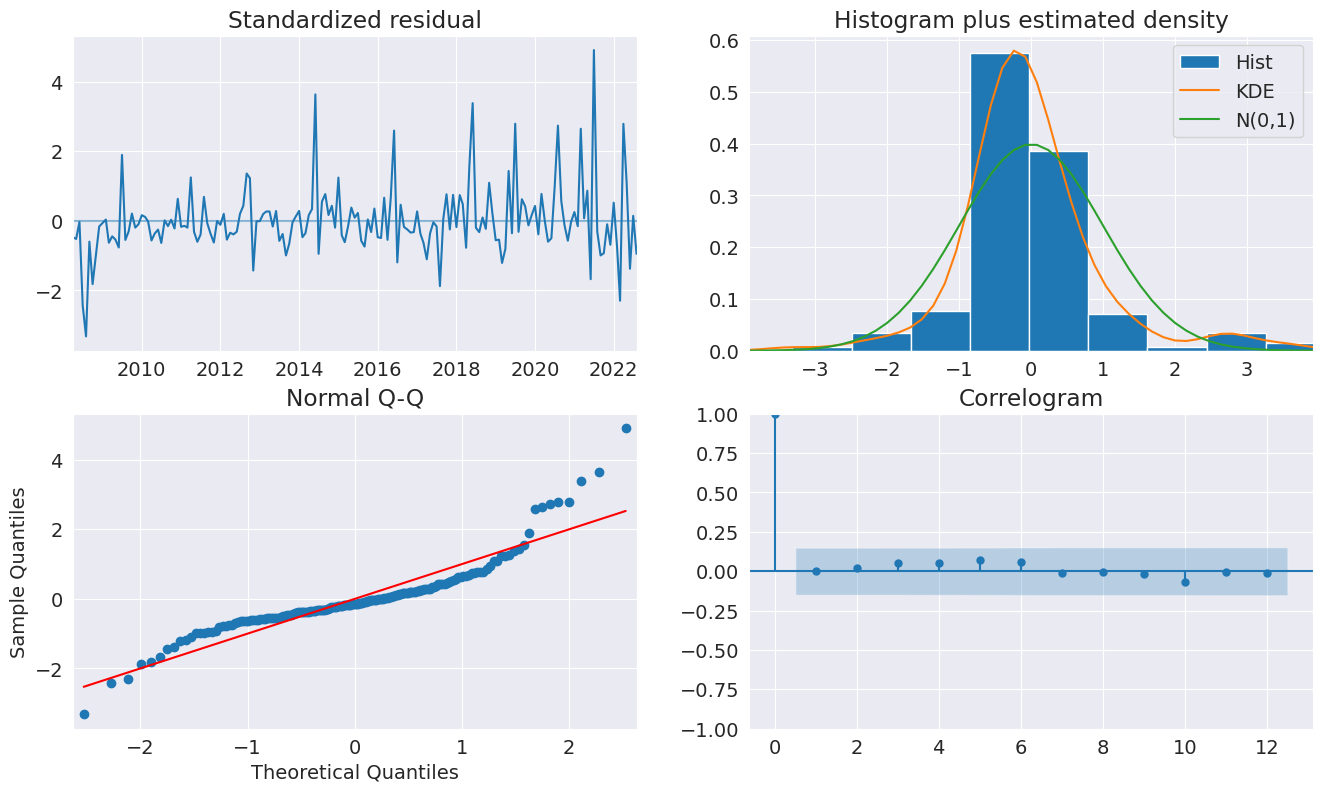

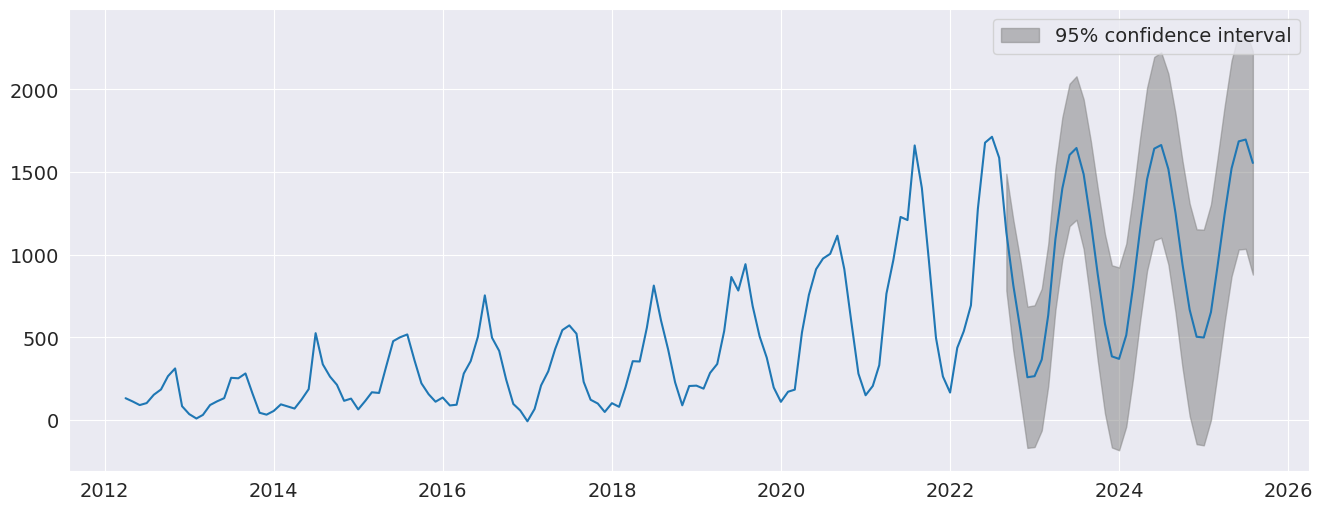

In [218]:
# Imazon SAD (monthly)
mod = AutoReg(data_pivot[series[2]].dropna(), 12, old_names=False)
res = mod.fit()
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=12, fig=fig)
fig2 = res.plot_predict(60, 220)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            deter_merge   No. Observations:                  186
Model:                    AutoReg(12)   Log Likelihood               -1182.284
Method:               Conditional MLE   S.D. of innovations            216.112
Date:                Wed, 21 Dec 2022   AIC                           2392.568
Time:                        12:13:25   BIC                           2436.795
Sample:                    04-01-2008   HQIC                          2410.509
                         - 09-01-2022                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              29.8839     38.532      0.776      0.438     -45.638     105.405
deter_merge.L1      0.5745      0.074      7.750      0.000       0.429       0.720
deter_merge.L2      0.1032      0.083      1.237      0.216      -0.060       0.267
deter_merge.L3     -0.1555      0.083     -1.863      0.062      -0.319       0.008
deter_merge.L4      0.1639      0.084      1.960      0.050   -3.88e-05       0.328
deter_merge.L5     -0.1730      0.084     -2.071      0.038      -0.337      -0.009
deter_merge.L6      0.0428      0.086      0.498      0.619      -0.126       0.211
deter_merge.L7     -0.0458      0.086     -0.532      0.595      -0.215       0.123
deter_merge.L8     -0.1160      0.085     -1.366      0.172      -0.283       0.050
deter_merge.L9      0.1819      0.085      2.132      0.033       0.015       0.349
deter_merge.L10     0.1618      0.083      1.960      0.050    2.11e-05       0.324
deter_merge.L11     0.1177      0.083      1.418      0.156      -0.045       0.280
deter_merge.L12     0.0924      0.072      1.286      0.198      -0.048       0.233
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0104           -0.0000j            1.0104           -0.0000
AR.2             0.8739           -0.5065j            1.0101           -0.0836
AR.3             0.8739           +0.5065j            1.0101            0.0836
AR.4             0.4653           -1.0315j            1.1316           -0.1826
AR.5             0.4653           +1.0315j            1.1316            0.1826
AR.6            -1.3288           -0.0000j            1.3288           -0.5000
AR.7            -1.2377           -0.4877j            1.3303           -0.4403
AR.8            -1.2377           +0.4877j            1.3303            0.4403
AR.9            -0.4927           -1.1543j            1.2551           -0.3142
AR.10           -0.4927           +1.1543j            1.2551            0.3142
AR.11           -0.0863           -1.4849j            1.4874           -0.2592
AR.12           -0.0863           +1.4849j            1.4874            0.2592
------------------------------------------------------------------------------
"""

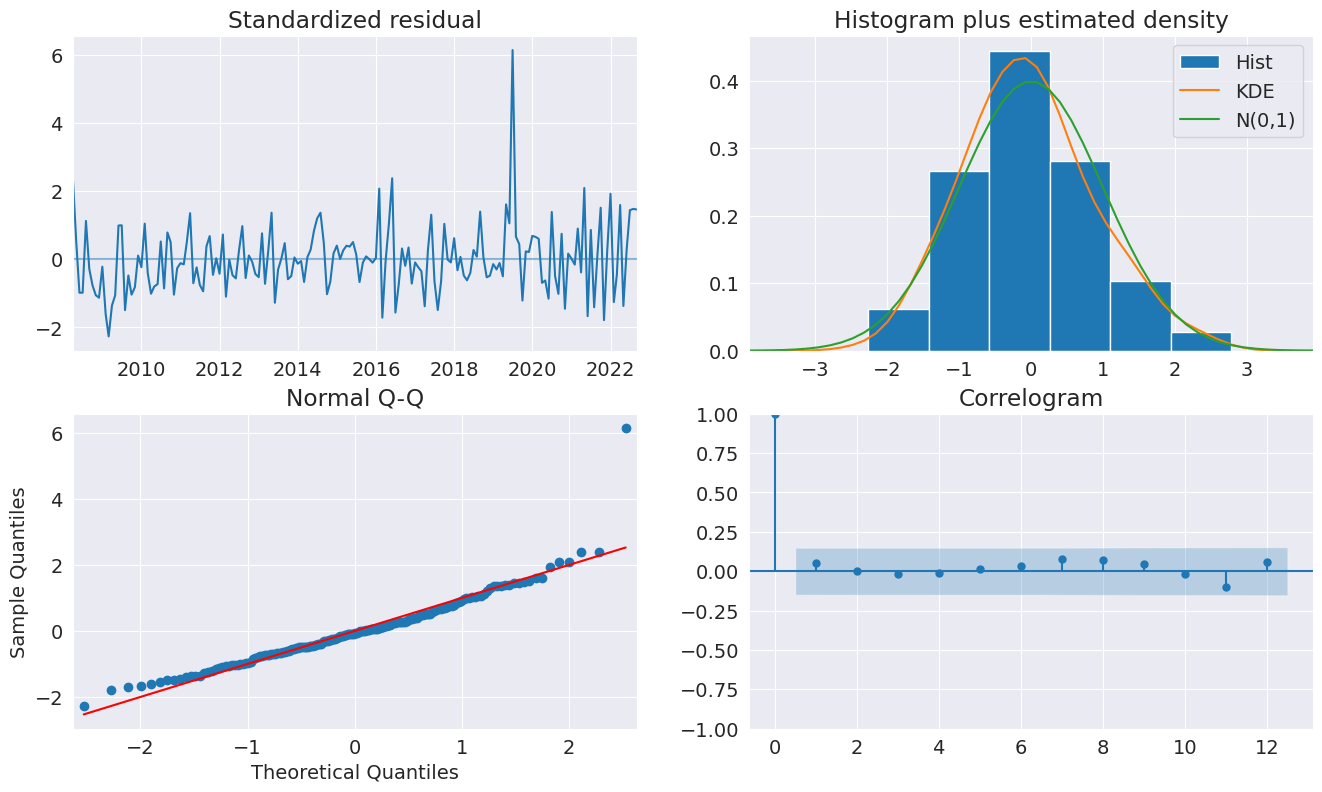

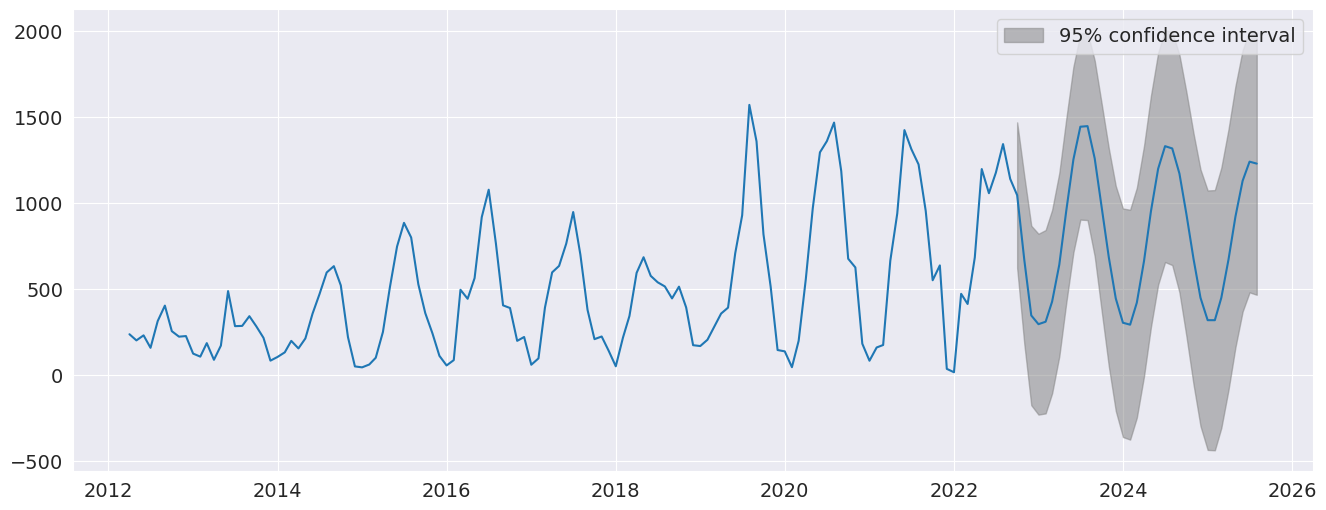

In [219]:
# deter (monthly)
mod = AutoReg(data_pivot[series[3]].dropna(), 12, old_names=False)
res = mod.fit()
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=12, fig=fig)
fig2 = res.plot_predict(60, 220)
res.summary()

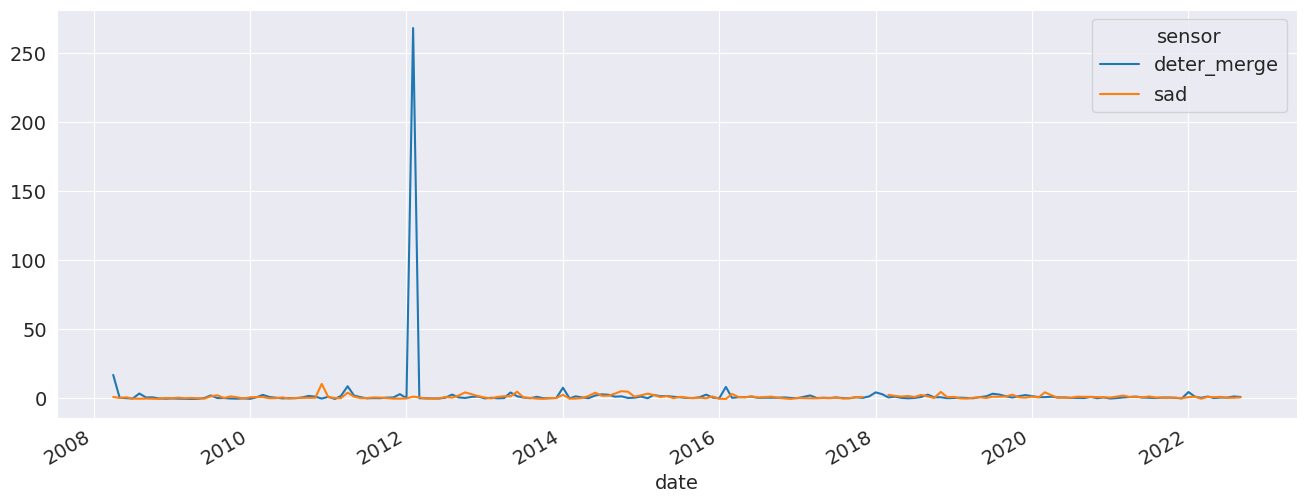

In [129]:
data_pivot = data_pivot[series].pct_change(12).dropna()
fig, ax = plt.subplots()
ax = data_pivot.plot(ax=ax)

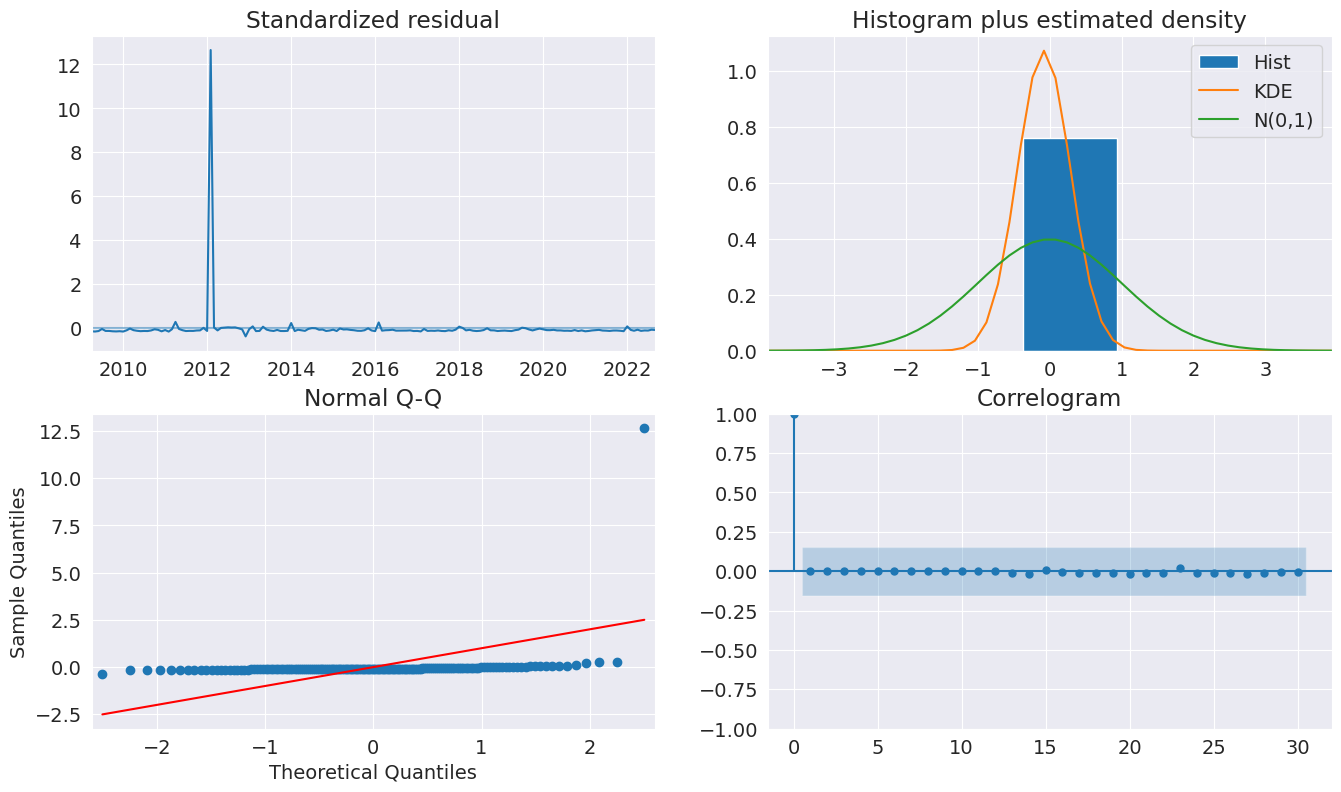

In [85]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=30, fig=fig)